In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
random_state = None
# rng = np.random.default_rng(0)
rng = np.random.RandomState(random_state)

In [3]:
def normalize(v, eps=1e-9):
    n = np.linalg.norm(v) + eps
    return v / n

def cosine_sim(a, b):
    return float(np.dot(normalize(a), normalize(b)))

In [4]:
#######################################################################################################################

class AgentTS:
    user_no = 0
    def __init__(self, user_dim, interest_dim, lambda0=1, sigma=1, forgetting_decay=1):
        self.user_dim = user_dim
        self.interest_dim = interest_dim
        self.u = normalize(rng.normal(size=user_dim))
        self.theta_true = normalize(rng.uniform(size=interest_dim))

        self.lambda0 = lambda0      # λ_0·I : Ridge Reguarization parameters (얼마나 prior를 신뢰할지?)
        self.sigma2 = sigma**2      # sigma σ : observation noise std (얼마나 관측 reward가 noise한지?)
        self.forgetting_decay = forgetting_decay    # Non-stationary reward 가정시 기존 matrix를 얼마나 decay할 것인지?

        self.A = lambda0 * np.eye(interest_dim)
        self.b = np.zeros(interest_dim)

        self.mu = rng.uniform(size=interest_dim)*0.1      # 현재 추정된 interest Mean
        self.Sigma = np.linalg.inv(self.A)      # 현재 추정된 interest Covariance
        AgentTS.user_no += 1
        self.user_no = AgentTS.user_no

        self.sampled_interest_vec = None

    def rep_context(self):
        return normalize(np.concatenate([self.u, self.mu]))

    def sample_interest(self):
        self.sampled_interest_vec = rng.multivariate_normal(self.mu, self.Sigma)
        return self.sampled_interest_vec

    def update(self, interest_other, r, Sigma_other=None):
        # x_interest = z_other[-self.interest_dim:]
        x_interest = interest_other.copy()

        # Non-stationary reward : forgetting mechanism
        self.A = self.forgetting_decay * self.A
        self.b = self.forgetting_decay * self.b

        #
        E_xx = np.outer(x_interest, x_interest)
        # if Sigma_other is not None:
        #     E_xx += Sigma_other

        self.A += (1/ self.sigma2) * E_xx    # += 1/(σ^2) * (X_I^T X_I)
        self.b += (1/ self.sigma2) * x_interest * r        # +=  1/(σ^2) * (X_I r)

        # (통상버전 : O(n^3)) -----------------------------------------
        # self.Sigma = np.linalg.inv(self.A)
        # -----------------------------------------------------------

        # (Sherman–Morrison : O(n^2)) -------------------------------
        v = (1.0/np.sqrt(self.sigma2)) * interest_other
        Ainv_v = self.Sigma @ v
        denom = 1.0 + v.T @ Ainv_v
        self.Sigma -= np.outer(Ainv_v, Ainv_v) / denom
        # -----------------------------------------------------------

        self.mu = self.Sigma @ self.b

    def full_context_true(self):
        return normalize(np.concatenate([self.u, self.theta_true]))

    def __repr__(self):
        return f"UserAgent_{self.user_no}"

In [5]:
#######################################################################################################################

# -----------------------------------------------------------------------------------------------
# Global Optima Matching
# 1) hungarian matching
from scipy.optimize import linear_sum_assignment
def hungarian(similarity_matrix):
    S_max = similarity_matrix.max()         # 행렬 최대값
    cost_matrix = S_max - similarity_matrix     # 비용행렬
    np.fill_diagonal(cost_matrix, np.inf)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    optimal_matching_values = similarity_matrix[row_ind, col_ind]
    matching_result = np.concatenate([row_ind[np.newaxis,...].T, col_ind[np.newaxis,...].T], axis=-1).T
    return matching_result, optimal_matching_values


# 2) 일반 그래프 최대 가중 매칭(Blossom)
import networkx as nx
def blossom_max_weight_matching(similarity_matrix):
    n = similarity_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            w = similarity_matrix[i, j]
            if np.isfinite(w):
                G.add_edge(i, j, weight=float(w))
    # 최대 가중 + 최대 카디널리티(가능한 많이 페어링)
    matching = nx.algorithms.matching.max_weight_matching(
        G, maxcardinality=True, weight='weight'
    )

    # matching result processing
    pair_half = list(matching)  # (i, j) 튜플들의 집합
    pair_half_np =  np.stack(pair_half)
    pair_np = np.concatenate([pair_half_np, pair_half_np[:, ::-1]], axis=0)
    sort_idx = np.argsort(pair_np[:,0])
    matching_result = pair_np[sort_idx].T

    # optimal_matching_values
    row_ind = matching_result[0]
    col_ind = matching_result[1]
    optimal_matching_values = similarity_matrix[row_ind, col_ind]
    return matching_result, optimal_matching_values



In [6]:

# -----------------------------------------------------------------------------------------------

# Local Optima Matching
import numpy as np
def greedy_matching(similarity_matrix):
    """
    유사도 행렬을 한 번 정렬한 후 탐욕적으로 매칭을 수행합니다.
    O(N^2 log N) 복잡도로, O(N^3)에 가까운 반복적 argmax 방식보다 빠릅니다.

    Args:
        similarity_matrix (np.ndarray): N x N 유사도 행렬.

    Returns:
        tuple: (matching_result, optimal_matching_values)
    """
    N = similarity_matrix.shape[0]

    # 1. 유사도 행렬에서 매칭 후보 쌍(i, j)만 추출합니다. (i < j 조건)
    # 삼각 행렬 인덱스 추출 (자기 자신과의 매칭 방지)
    iu = np.triu_indices(N, k=1)

    # 2. 모든 유사도 값을 추출하고 내림차순으로 정렬합니다.
    flat_similarities = similarity_matrix[iu]

    # 유사도 값이 높은 순서(내림차순)로 정렬하기 위한 인덱스
    sort_idx = np.argsort(flat_similarities)[::-1]

    # 정렬된 유사도 값과 해당 쌍의 인덱스
    sorted_values = flat_similarities[sort_idx]
    sorted_pairs = np.column_stack(iu)[sort_idx] # (row, col) 쌍

    # 매칭 결과를 저장할 리스트와 매칭된 유저 집합
    matched_pairs = []
    matched_values = []
    matched_indices = set()

    # 3. 정렬된 쌍을 순회하며 매칭합니다. (O(N^2) 순회)
    for value, (i, j) in zip(sorted_values, sorted_pairs):
        # 이미 i 또는 j가 매칭되었는지 확인 (O(1) set lookup)
        if i not in matched_indices and j not in matched_indices:
            # 매칭 확정
            matched_pairs.append((i, j))
            matched_values.append(value)

            # 유저 제거 (논리적 제거)
            matched_indices.add(i)
            matched_indices.add(j)

            # 매칭이 절반 이상 완료되면 종료
            if len(matched_indices) >= N - 1:
                break

    if not matched_pairs:
        return np.array([[], []]), np.array([])

    # 4. 결과 포맷팅 (이 부분은 이전 코드와 동일)
    matched_pairs_np = np.array(matched_pairs)

    # (i, j)뿐만 아니라 (j, i)도 포함
    all_pairs = np.concatenate([matched_pairs_np, matched_pairs_np[:, ::-1]], axis=0)
    all_values = np.concatenate([np.array(matched_values), np.array(matched_values)], axis=0)

    # 행 인덱스(user_i) 기준으로 정렬
    sort_idx = np.argsort(all_pairs[:, 0])
    matching_result = all_pairs[sort_idx].T
    optimal_matching_values = all_values[sort_idx]

    return matching_result, optimal_matching_values



class KNN_GreedyMatching():
    def __init__(self, k=None):
        self.k = k

    def knn_greedy_matching(self, similarity_matrix):
        """
        유사도 행렬을 기반으로, 각 유저의 k명의 가장 유사한 후보군 내에서만
        탐욕적으로 매칭을 수행하는 근사 매칭 함수입니다.

        Args:
            similarity_matrix (np.ndarray): N x N 유사도 행렬.
            k (int): 각 유저가 고려할 이웃의 최대 수.

        Returns:
            tuple: (matching_result, optimal_matching_values)
                matching_result (np.ndarray): 매칭된 쌍의 인덱스 (2, M).
                optimal_matching_values (np.ndarray): 매칭된 쌍의 유사도 값 (M,).
        """
        N = similarity_matrix.shape[0]
        k = self.k
        if k is None or (k >= N - 1):
            # k가 N보다 크면 그냥 일반적인 탐욕적 매칭과 동일
            return greedy_matching(similarity_matrix)

        # 1. k-NN 기반 후보 쌍만 추출하여 정렬합니다.

        # 1-1. 각 유저별 k명의 이웃 인덱스를 찾습니다.
        # np.argsort는 기본적으로 오름차순. [::-1]로 내림차순 정렬 후, k개 선택.
        # 자기 자신(가장 유사도 1.0)을 제외하고, 인접한 k개의 인덱스를 찾습니다.

        # 유사도 행렬의 각 행(유저 i)에서 k+1번째로 유사한 인덱스까지
        # 즉, 자기 자신(0순위) 포함 k+1개
        k_plus_1_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :k+1]

        # 1-2. 매칭 후보 (쌍) 리스트 생성
        # 모든 유저 i에 대해, 그들의 k-NN 후보 j만을 추출합니다. (i < j 조건 만족)
        # 이는 중복 쌍을 피하고 대칭성을 깨지 않기 위함입니다.

        candidate_pairs = set()

        for i in range(N):
            # 유저 i의 k-NN 후보 목록
            neighbors = k_plus_1_indices[i]

            for j in neighbors:
                # 1. 자기 자신과의 매칭 제외
                if i == j:
                    continue
                # 2. 이미 (j, i)로 처리된 쌍을 피하기 위해 정규화된 쌍 (min, max)만 추가
                pair = tuple(sorted((i, j)))
                candidate_pairs.add(pair)

        # 2. 후보 쌍의 유사도 값을 추출하고 내림차순으로 정렬합니다.

        # 후보 쌍 (i, j)와 해당 유사도 값 추출
        pairs_list = np.array(list(candidate_pairs))
        flat_similarities = similarity_matrix[pairs_list[:, 0], pairs_list[:, 1]]

        # 유사도 값이 높은 순서(내림차순)로 정렬하기 위한 인덱스
        sort_idx = np.argsort(flat_similarities)[::-1]

        sorted_values = flat_similarities[sort_idx]
        sorted_pairs = pairs_list[sort_idx]

        # 3. 탐욕적으로 매칭합니다. (나머지 과정은 optimized_greedy_matching과 동일)

        matched_pairs = []
        matched_values = []
        matched_indices = set()

        for value, (i, j) in zip(sorted_values, sorted_pairs):
            if i not in matched_indices and j not in matched_indices:
                # 매칭 확정
                matched_pairs.append((i, j))
                matched_values.append(value)

                # 유저 제거
                matched_indices.add(i)
                matched_indices.add(j)

                if len(matched_indices) >= N - 1:
                    break

        if not matched_pairs:
            return np.array([[], []]), np.array([])

        # 4. 결과 포맷팅
        matched_pairs_np = np.array(matched_pairs)

        # (i, j)뿐만 아니라 (j, i)도 포함하여 정렬
        all_pairs = np.concatenate([matched_pairs_np, matched_pairs_np[:, ::-1]], axis=0)
        all_values = np.concatenate([np.array(matched_values), np.array(matched_values)], axis=0)

        # 행 인덱스(user_i) 기준으로 정렬
        sort_idx = np.argsort(all_pairs[:, 0])
        matching_result = all_pairs[sort_idx].T
        optimal_matching_values = all_values[sort_idx]

        return matching_result, optimal_matching_values

# -----------------------------------------------------------------------------------------------

#######################################################################################################################


In [7]:
########################################################################################
INTEREST_DIM = 8
users = [AgentTS(user_dim=4, interest_dim=INTEREST_DIM) for _ in range(5)]

# True matching
users_true_vec = np.array([np.concatenate([user.u, user.theta_true], axis=-1) for user in users])
SM_true = users_true_vec @ users_true_vec.T

# true_matching, true_matching_values = hungarian(SM_true)  # True matching
true_matching, true_matching_values = blossom_max_weight_matching(SM_true)  # True matching
print('< true_matching >')
print(true_matching)
print(true_matching_values)


< true_matching >
[[0 1 2 4]
 [4 2 1 0]]
[1.04221497 1.68794946 1.68794946 1.04221497]


In [8]:
# sample matching
users_samples_vec = np.array([np.concatenate([user.u, user.sample_interest()], axis=-1) for user in users])
SM_samples = users_samples_vec @ users_samples_vec.T

# sample_matching, sample_matching_values = hungarian(SM_samples)
sample_matching, sample_matching_values = blossom_max_weight_matching(SM_samples)
print('< sampling_matching >')
print(sample_matching)
print(sample_matching_values)

< sampling_matching >
[[0 1 2 3]
 [1 0 3 2]]
[3.85022474 3.85022474 1.36058252 1.36058252]


In [9]:
########################################################################################
# After Maching, Revealed Rewards
def revealed_reward(true_similarity_matrix, sample_matching, noise_std=0.1):
    mu_rewards = true_similarity_matrix.copy()
    # true_similarity_matrix_copy = true_similarity_matrix.copy()
    # np.fill_diagonal(true_similarity_matrix_copy, -np.inf)
    # np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=1)
    # mu_rewards = 1/2*(np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=0)) + 1/2*(np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=0)).T

    reward_noise_gen = rng.random(size=mu_rewards.shape)*noise_std-noise_std/2
    reward_noise_gen = (reward_noise_gen + reward_noise_gen.T)/2
    np.fill_diagonal(reward_noise_gen, 0)

    revealed_rewards = mu_rewards+reward_noise_gen
    # revealed_rewards = np.clip(mu_rewards+reward_noise_gen, a_min=0, a_max=1)
    return revealed_rewards[sample_matching[0], sample_matching[1]]


In [10]:
rewards_obs = revealed_reward(SM_true, sample_matching)
print(f"revealed rewards : {rewards_obs}")

revealed rewards : [0.5527785  0.5527785  0.59101496 0.59101496]


In [11]:
########################################################################################
def step_update(users, sample_matching, revealed_rewards):
    """
    매칭 결과와 관측된 보상을 바탕으로 각 사용자의 취향 파라미터(mu, Sigma)를 업데이트합니다.
    (선형 가우시안 베이즈 회귀)

    users: AgentTS 객체 리스트
    sample_matching: (2, N) 형태의 매칭 결과 배열. [0]은 행 인덱스, [1]은 열 인덱스.
    revealed_rewards: 매칭된 쌍에 대해 관측된 보상 배열.
    """

    # 1. 매칭 결과에서 쌍(i, j)을 추출합니다.
    # sample_matching[0]은 행 인덱스 (사용자 i), sample_matching[1]은 열 인덱스 (사용자 j)
    matched_pairs = list(zip(sample_matching[0], sample_matching[1]))

    # 2. 매칭된 각 쌍에 대해 대칭적으로 업데이트를 수행합니다.
    for k, (i_idx, j_idx) in enumerate(matched_pairs):
        user_i = users[i_idx]
        user_j = users[j_idx]
        reward = revealed_rewards[k]

        # ------------------------------------------------------------
        # 상대방 관심 vector
        # interest_j = user_j.mu     # update할때는 mu로 (안정성을 위해)
        # interest_i = user_i.mu     # update할때는 mu로 (안정성을 위해)
        interest_j = user_j.sampled_interest_vec
        interest_i = user_i.sampled_interest_vec

        # 상대방 Sigma
        Sigma_j = user_j.Sigma
        Sigma_i = user_i.Sigma

        # # Agent Update
        user_i.update(interest_j, reward, Sigma_j)
        user_j.update(interest_i, reward, Sigma_i)
        # user_i.update(interest_j, reward, Sigma_j)
        # user_j.update(interest_i, reward, Sigma_i)
        # ------------------------------------------------------------
    return users


In [12]:
##########################################################################################
##########################################################################################
# [1 to 1 Matching Simulation] ###########################################################


INTEREST_DIM = 16
users = [AgentTS(user_dim=4, interest_dim=INTEREST_DIM, forgetting_decay=0.99) for _ in range(32)]
# np.linalg.det(users[0].A)

# true matching
users_true_vec = np.array([np.concatenate([user.u, user.theta_true], axis=-1) for user in users])
SM_true = users_true_vec @ users_true_vec.T

# true_matching, true_matching_values = hungarian(SM_true)  # True matching
true_matching, true_matching_values = blossom_max_weight_matching(SM_true)  # True matching

print('< true_matching >')
print(true_matching)
print(true_matching_values)

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31]
 [29 11 16  5 13  3 12 22 14 20 31  1  6  4  8 27  2 25 30 21  9 19  7 28
  26 17 24 15 23  0 18 10]]
[1.50157426 1.75564242 1.68314649 1.44925212 1.65239874 1.44925212
 1.54251303 1.76142757 1.74207867 1.81293873 1.33480744 1.75564242
 1.54251303 1.65239874 1.74207867 1.40966597 1.68314649 1.5576442
 1.78208039 1.60499174 1.81293873 1.60499174 1.76142757 1.60567095
 1.36114245 1.5576442  1.36114245 1.40966597 1.60567095 1.50157426
 1.78208039 1.33480744]


In [13]:
# matching
rewards_obs_list = []

  0%|          | 0/300 [00:00<?, ?it/s]

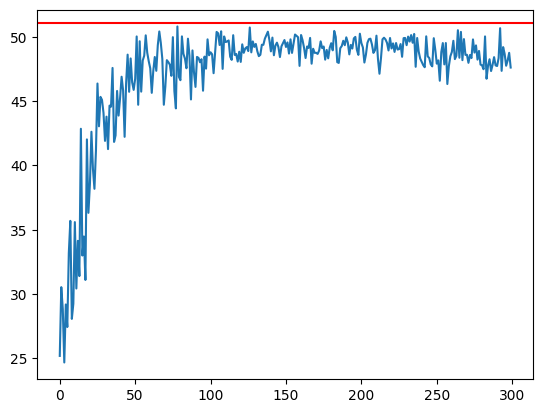

In [14]:
# matching
# matching_function = KNN_GreedyMatching(k=int(np.sqrt(SM_true.shape[0]))).knn_greedy_matching   # hungarian, blossom_max_weight_matching, greedy_matching, KNN_GreedyMatching(k=10).knn_greedy_matching
matching_function = greedy_matching
for _ in tqdm(range(300)):
    # sample matching
    user_context = np.array([user.u for user in users])
    user_sample_interest = np.array([user.sample_interest() for user in users])
    users_samples_vec = np.concatenate([user_context, user_sample_interest], axis=-1)
    SM_samples = users_samples_vec @ users_samples_vec.T

    sample_matching, sample_matching_values = matching_function(SM_samples)
    rewards_obs = revealed_reward(SM_true, sample_matching, noise_std=0.3)
    users = step_update(users, sample_matching, rewards_obs)

    rewards_obs_list.append(np.sum(rewards_obs))    # rewards
    
plt.plot(rewards_obs_list)
plt.axhline(np.sum(true_matching_values), color='red')
plt.show()
# [user.theta_true for user in users]
# [user.mu for user in users]

In [15]:
# sample matching
# users_samples_vec = np.array([np.concatenate([user.u, user.sample_interest()], axis=-1) for user in users])
users_samples_vec = np.array([np.concatenate([user.u, user.mu], axis=-1) for user in users])
SM_samples = users_samples_vec @ users_samples_vec.T

# sample_matching, sample_matching_values = matching_function(SM_samples)
sample_matching, sample_matching_values = blossom_max_weight_matching(SM_samples)
print('< sampling_matching >')
print(sample_matching)
print(sample_matching_values)
print(f"total return rewards (training) : {sample_matching_values.sum():.3f}")


< sampling_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31]
 [29 11 16 22 13 17 10 12 19 20  6  1  7  4 15 14  2  5 30  8  9 25  3 28
  27 21 31 24 23  0 18 26]]
[1.41119779 1.68196063 1.61091374 1.53526889 1.53506641 0.7836536
 1.18302302 1.54547141 1.71653358 1.74089002 1.18302302 1.68196063
 1.54547141 1.53506641 1.30634707 1.30634707 1.61091374 0.7836536
 1.70561156 1.71653358 1.74089002 1.59284905 1.53526889 1.59918656
 0.04371347 1.59284905 1.1184591  0.04371347 1.59918656 1.41119779
 1.70561156 1.1184591 ]
total return rewards (training) : 44.220


In [16]:
print('< true_matching >')
print(true_matching)
print(true_matching_values)
print(f"total return rewards (true) : {true_matching_values.sum():.3f}")

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31]
 [29 11 16  5 13  3 12 22 14 20 31  1  6  4  8 27  2 25 30 21  9 19  7 28
  26 17 24 15 23  0 18 10]]
[1.50157426 1.75564242 1.68314649 1.44925212 1.65239874 1.44925212
 1.54251303 1.76142757 1.74207867 1.81293873 1.33480744 1.75564242
 1.54251303 1.65239874 1.74207867 1.40966597 1.68314649 1.5576442
 1.78208039 1.60499174 1.81293873 1.60499174 1.76142757 1.60567095
 1.36114245 1.5576442  1.36114245 1.40966597 1.60567095 1.50157426
 1.78208039 1.33480744]
total return rewards (true) : 51.114
